# Read `POST` nodes and attempt autocorrelation

1. Read only points from `.POST` files which are internally H5.
2. query the following points:

In [1]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Define the data folder - must include .h5 cas and dat files.
data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"

#from cmcrameri import cm

In [2]:
# Check if NodeX is not defined
if 'NodeX' not in globals():
    # Find .cas.post files
    case_files = [f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
    
    if case_files:
        fname = os.path.join(data_folder, case_files[0])
        
        # Read the mesh data from the HDF5 file
        with h5py.File(fname, 'r') as f:
            vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
        
        # Extract NodeX and NodeY
        node_x = vertex_list[0]
        node_y = vertex_list[1]
    
    # Clean up variables
    del case_files

# Define constants
tw = 308
yw = -0.015

# Find *dat.post files
data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]

def get_time(data_file):
    data_file = data_file
    return float(data_file.split(".")[1].split("-")[-1])

data_files = sorted(data_files, key=get_time)


if 'T' not in globals():
    if data_files:
        fname = os.path.join(data_folder, data_files[-1])
        
        # Read temperature and velocity data from the HDF5 file
        with h5py.File(fname, 'r') as f:
            T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
            U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
            V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]


Plot the nodes with U,V,T

Text(0.5, 1.0, 'Temperature (K)')

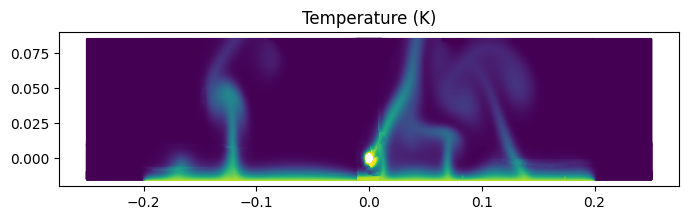

In [4]:
# Proof that they are mapped properly
fig, ax = plt.subplots(figsize=(8,2))
ax.scatter(node_x, node_y, c=T, cmap='viridis', s=1)
ax.set_title("Temperature (K)")

Text(0.5, 1.0, 'U (m/s)')

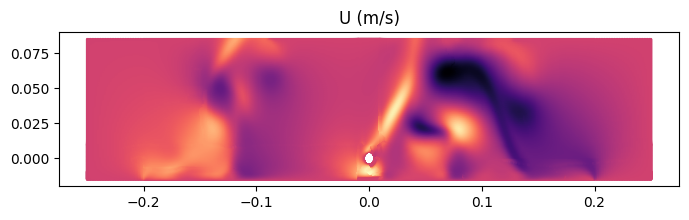

In [5]:
fig, ax = plt.subplots(figsize=(8,2))
ax.scatter(node_x, node_y, c=U, cmap='magma', s=1)
ax.set_title("U (m/s)")

Text(0.5, 1.0, 'V (m/s)')

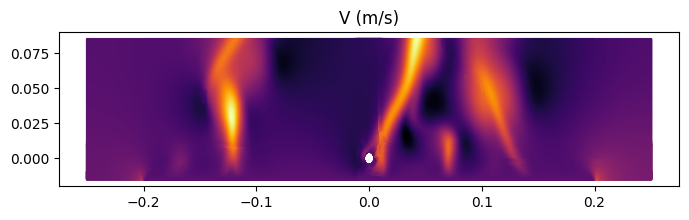

In [6]:
fig, ax = plt.subplots(figsize=(8,2))
ax.scatter(node_x, node_y, c=V, cmap='inferno', s=1)
ax.set_title("V (m/s)")

## Test point querying

In [7]:
def query_point(node_x, node_y, data_file, z, query_x, query_y):
    """Given a set of cell coordinates node_x, node_y, and a list of requested coordinates query_x, query_y,
    obtain the corresponding z values from the entire z array.
    """
    # Convert lists to numpy arrays if they are not already
    query_x = np.array(query_x)
    query_y = np.array(query_y)

    time = float(data_file.split(".")[1].split("-")[-1])
    
    # Initialize lists to store results
    results = []
    
    # Tolerances - found with trial and error. 
    tolerance = 1e-4
    rtol = 1e-2
    
    for x, y in zip(query_x, query_y):
        queried_indices = np.where(
            np.isclose(node_x, x, atol=tolerance, rtol=rtol) &
            np.isclose(node_y, y, atol=tolerance, rtol=rtol)
        )
        
        # This will likely return multiple values - this is the result of the 
        # first combination of tolerances that returns nonzero close values.
        # It is assumed that they are close enough in value so that we 
        # can take the average of the values corresponding to the found indices
        close_x = np.nanmean(node_x[queried_indices])
        close_y = np.nanmean(node_y[queried_indices])
        close_z = np.nanmean(z[queried_indices])
        
        results.append((queried_indices, close_x, close_y, close_z, time))
    
    return results


In [9]:
results = query_point(node_x, node_y, data_files[-1], T, [0.1, 0.005], [-0.01, 0.01])

# This function works for multiple query points. 
for i in results:
    print(i)

((array([155306, 155360, 155361, 155414, 155415, 155467, 155468, 155521,
       155522, 155573, 155574, 155626]),), np.float64(0.09989350768121912), np.float64(-0.009998062689620252), np.float64(302.9278686746434), 27763.0)
((array([132276, 132322, 132368, 132369, 132413, 132414, 132458, 132505,
       132551, 132598]),), np.float64(0.005002653899166811), np.float64(0.009974641896472278), np.float64(305.2258813735107), 27763.0)


Attempt to build a point time series across all post files. 

In [10]:
def get_nodes_from_casefile(data_folder):

    # Find .cas.post files
    case_files = [f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
    
    if case_files:
        fname = os.path.join(data_folder, case_files[0])
        
        # Read the mesh data from the HDF5 file
        with h5py.File(fname, 'r') as f:
            vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
        
        # Extract NodeX and NodeY
        node_x = vertex_list[0]
        node_y = vertex_list[1]
    
        return node_x, node_y

def get_z_for_datafile(data_file):
    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]
    return U, V, T

def get_query_point_from_datafile(node_x, node_y, data_file, query_x, query_y):
    

    _, _, T = get_z_for_datafile(data_file)

    results = query_point(node_x, node_y, data_file, T, query_x, query_y)

    #queried_indices, close_x, close_y, close_u = query_point(node_x, node_y, U, query_x, query_y)
    #queried_indices, close_x, close_y, close_v = query_point(node_x, node_y, V, query_x, query_y)

    return results 

    
    

In [11]:
node_x, node_y = get_nodes_from_casefile(data_folder)


query_x = [0.1, 0.005]
query_y = [-0.01, 0.01]

# Test for 1 data file
get_query_point_from_datafile(node_x, node_y, data_files[-1], query_x, query_y)

[((array([155306, 155360, 155361, 155414, 155415, 155467, 155468, 155521,
          155522, 155573, 155574, 155626]),),
  np.float64(0.09989350768121912),
  np.float64(-0.009998062689620252),
  np.float64(302.9278686746434),
  27763.0),
 ((array([132276, 132322, 132368, 132369, 132413, 132414, 132458, 132505,
          132551, 132598]),),
  np.float64(0.005002653899166811),
  np.float64(0.009974641896472278),
  np.float64(305.2258813735107),
  27763.0)]

In [12]:
from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning
        
# Use LokyBackend to protect the h5py routine
timeseries_results = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(get_query_point_from_datafile) \
 (node_x, node_y, data_file, query_x, query_y
 ) for data_file in data_files[:15001])

env: PYTHONWARNINGS=ignore::UserWarning


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 626 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2626 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3376 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4226 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6226 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 7376 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 8626 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 11426 tasks      

In [13]:
# There are 3 dimensions to the results array: (timestep, query point, result data)
timeseries_results_array = np.array(timeseries_results, dtype=object)
queried_x_points = timeseries_results_array[:,:,1]
queried_y_points = timeseries_results_array[:,:,2]
queried_t_points = timeseries_results_array[:,:,3]
times = np.array(timeseries_results_array[:,:,4][:,-1])

(100.0, 851.0)

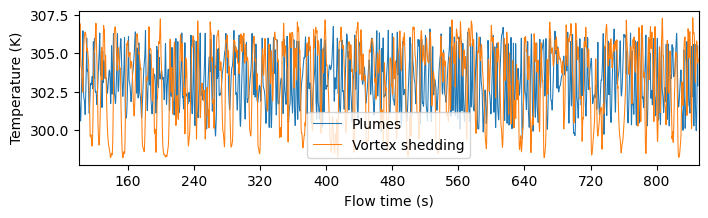

In [26]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(8,2))

ax.plot(times*0.05, queried_t_points[:,0], linewidth=0.75, label="Plumes")
ax.plot(times*0.05, queried_t_points[:,1], linewidth=0.75, label="Vortex shedding")
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)) 

ax.set_xlabel("Flow time (s)")
ax.set_ylabel("Temperature (K)")

ax.legend()

ax.set_xlim([100,851])

In [28]:
def get_autocorrelation(z):
    # Compute the autocorrelation
    autocorr = np.correlate(z - np.mean(z), z - np.mean(z), mode='full')
    # Take only the 2nd half to get rid of negative lags
    autocorr = autocorr[autocorr.size // 2:]
    autocorr /= autocorr[0]
    return autocorr

vortex_autocorr = get_autocorrelation(queried_t_points[:,1])
plume_autocorr = get_autocorrelation(queried_t_points[:,0])

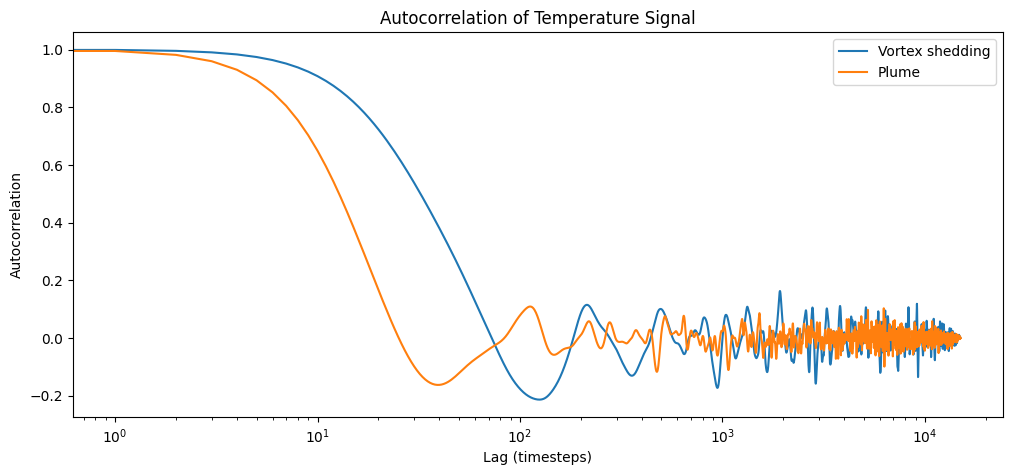

In [29]:
# Plot the autocorrelation
fig, ax = plt.subplots(figsize=(12,5))
#ax.plot(autocorr2)
ax.semilogx(vortex_autocorr, label="Vortex shedding")
ax.semilogx(plume_autocorr, label="Plume")
ax.set_title('Autocorrelation of Temperature Signal')
ax.set_xlabel('Lag (timesteps)')
ax.set_ylabel('Autocorrelation')
ax.legend()